In [2]:
%matplotlib inline
import numpy as np
import random  as rd
from numba import jit
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import math
import random

init_particle:
[[  0.00000000e+00   0.00000000e+00]
 [  5.79000000e+10   0.00000000e+00]
 [  1.08900000e+11   0.00000000e+00]
 [  1.52100000e+11   0.00000000e+00]
 [  2.49200000e+11   0.00000000e+00]
 [  8.16600000e+11   0.00000000e+00]
 [  1.51450000e+12   0.00000000e+00]
 [  2.87250000e+12   0.00000000e+00]
 [  4.49510000e+12   0.00000000e+00]]
1557719819.52
init_v:
[[  0.00000000e+00   0.00000000e+00]
 [  2.94003348e-12   4.80143905e+04]
 [  2.14376718e-12   3.50103750e+04]
 [  1.81395685e-12   2.96241634e+04]
 [  1.41715561e-12   2.31439074e+04]
 [  7.82864987e-13   1.27851555e+04]
 [  5.74853155e-13   9.38806446e+03]
 [  4.17408741e-13   6.81680205e+03]
 [  3.33673625e-13   5.44930383e+03]]
init:
[[  6.48511377e+04   0.00000000e+00]
 [  4.79493876e+10   2.40071952e+10]
 [  1.06086756e+11   1.75051875e+10]
 [  1.50657766e+11   1.48120817e+10]
 [  2.48662773e+11   1.15719537e+10]
 [  8.16549978e+11   6.39257774e+09]
 [  1.51448539e+12   4.69403223e+09]
 [  2.87249594e+12   3.4084010

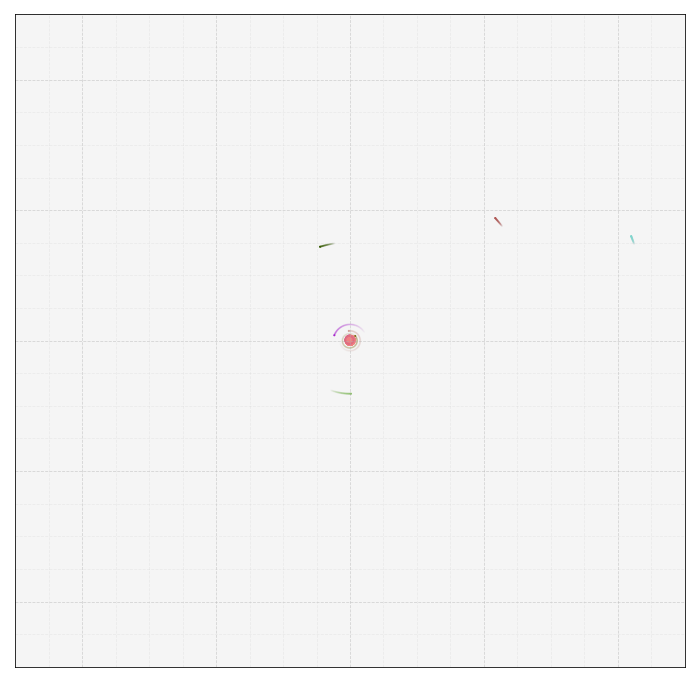

In [6]:
G = 6.67408e-11 # m**3 kg**-1 s**-2 ----- Gravitational constant
nParticles = 8
nStars = 1
r_planets = [5.79e10, 108.9e9, 152.1e9, 249.2e9, 816.6e9, 1514.5e9, 2872.5e9, 4495.1e9]
m_planets = [0.330e24, 4.87e24, 5.97e24, 0.642e24, 1898.0e24, 568.0e24, 86.8e24, 102e24]
nt_simulation = 600

# =======================================================================
# -----------------------------Positions---------------------------------
# =======================================================================

if nStars == 1:
    init_particle_x = np.hstack(([0], r_planets))
    init_particle_y = np.hstack(([0], [0, 0, 0, 0, 0, 0, 0, 0]))
if nStars == 2:
    init_particle_x = np.hstack(([1.5e11], [-1.5e11],
                                 (np.random.normal(0,1,nParticles))*1.5e12))
    init_particle_y = np.hstack(([0], [0], (np.random.normal(0,1,nParticles))*1.5e12))

init_particle = np.vstack((init_particle_x,init_particle_y)).T
print "init_particle:\n", init_particle

particlem = np.hstack(([2e30]*nStars, m_planets))
com = sum([particlem[j]*init_particle_x[j] for j in range(nParticles + nStars)]) / sum(particlem)
print com

# =======================================================================
# ----------------------------Velocities---------------------------------
# =======================================================================

if nStars == 1:
    init_v_x_stars = [0]
    init_v_y_stars = [0]
    init_v_x_planets = [math.copysign(np.sqrt(G * particlem[0] /
                                              np.sqrt(init_particle_x[ii]**2 +
                                                      init_particle_y[ii]**2)) *
                                      np.cos(np.arctan2(init_particle_y[ii],init_particle_x[ii])+(np.pi/2.)),
                                     - init_particle_y[ii])
                        for ii in range(nStars,nStars+nParticles)]
    init_v_y_planets = [math.copysign(np.sqrt(G * particlem[0] /
                                              np.sqrt(init_particle_x[ii]**2 +
                                                      init_particle_y[ii]**2)) *
                                      np.sin(np.arctan2(init_particle_y[ii],init_particle_x[ii])+(np.pi/2.)),
                                     init_particle_x[ii])
                        for ii in range(nStars,nStars+nParticles)]
    init_v_x = init_v_x_stars + init_v_x_planets
    init_v_y = init_v_y_stars + init_v_y_planets
    init_v = np.vstack((init_v_x,init_v_y)).T

if nStars == 2:
    init_v_x_stars = [0 for i in range(nStars)]
    init_v_y_stars = [math.copysign(np.sqrt(G * particlem[0] / (abs(4*init_particle_x[ii]))), 
                              init_particle_x[ii]) for ii in range(nStars)]

    init_v_x_planets = [math.copysign(np.sqrt(G * (particlem[0]+particlem[1]) /
                                              np.sqrt(init_particle_x[ii]**2 +
                                                      init_particle_y[ii]**2)) *
                                      np.cos(np.arctan2(init_particle_y[ii],init_particle_x[ii])+(np.pi/2.)),
                                     - init_particle_y[ii])
                        for ii in range(nStars,nStars+nParticles)]
    init_v_y_planets = [math.copysign(np.sqrt(G * (particlem[0]+particlem[1]) /
                                              np.sqrt(init_particle_x[ii]**2 +
                                                      init_particle_y[ii]**2)) *
                                      np.sin(np.arctan2(init_particle_y[ii],init_particle_x[ii])+(np.pi/2.)),
                                     init_particle_x[ii])
                        for ii in range(nStars,nStars+nParticles)]
    init_v_x = init_v_x_stars + init_v_x_planets
    init_v_y = init_v_y_stars + init_v_y_planets
    init_v = np.vstack((init_v_x,init_v_y)).T

print "init_v:\n", init_v

#=======================================================================
#--------------------------------Forces---------------------------------
#=======================================================================

def galsim(particle, particlev, particlem, nParticles, nStars):
    dt= .5e6
    G = 6.67408e-11
    eps = 1e7
    for i in range(nParticles + nStars):
        Fx = 0.0
        Fy = 0.0
        for j in range(nParticles + nStars):
            if j != i:
                dx = particle[j,0] - particle[i,0]
                dy = particle[j,1] - particle[i,1]
                dr = np.sqrt(dx**2 + dy**2)
                F = - G * particlem[i] * particlem[j] / (dr+eps)**2
                Fx += (math.copysign(F * np.cos(np.arctan(dy / dx)), dx))
                Fy += (math.copysign(F * np.sin(np.arctan(dy / dx)), dy))
        particlev[i, 0] += ((Fx / particlem[i]) * dt)
        particlev[i, 1] += ((Fy / particlem[i]) * dt)
    for i in range(nParticles + nStars):
        particle[i,0] += (particlev[i,0] * dt)
        particle[i,1] += (particlev[i,1] * dt)
    return particle, particlev

# =======================================================================
# -----------------------------Execution---------------------------------
# =======================================================================

init_gal = galsim(init_particle, init_v, particlem, nParticles, nStars)
print "init:\n", init_gal[0]
#Initializing lists
states = []
x = []
y = []

#Creating lists of the X and Y coordinates of each particle from t=0 to t=nt_simulation
for t in range(nt_simulation):
    gal_data = galsim(init_gal[0],init_gal[1],particlem, nParticles, nStars)
    states.append(gal_data[0])
    current_state = states[t]
    current_copy_x = list(current_state[:,0])
    x.insert(t,current_copy_x)
    current_copy_y = list(current_state[:,1])
    y.insert(t,current_copy_y)
    init_gal = gal_data
    
# =======================================================================
# =======================================================================
# ------------------------------Animation--------------------------------
# =======================================================================
# =======================================================================

planetc1 = np.array([random.uniform(0, 1) for i in range(nParticles+nStars)])
planetc2 = np.array([random.uniform(0, 1) for i in range(nParticles+nStars)])
planetc3 = np.array([random.uniform(0, 1) for i in range(nParticles+nStars)])

def initial():
    particles.set_offsets([])
    return particles,

def animate(i):
    j = 0
    ntrails = 50
    data = np.vstack((x[i], y[i])).T
    while j < i and j < ntrails:
        data = np.vstack((data, np.vstack((x[i-j],y[i-j])).T))
        j += 1
    particles.set_offsets(data)
    
    percentm = np.array([(particlem[i] / sum(particlem)) for i in range(len(particlem))])
    percentm = percentm / percentm.max()*100
    percentm = (np.ceil(percentm)).tolist() * ntrails
    particles.set_sizes(percentm)
    
# =======================================================================
# -------------------------------Colors!---------------------------------
# =======================================================================
    
    from matplotlib import colors
    init_alpha = [[1.]*nStars+[1.]*nParticles][0]
    init_decay = []
    for decay in np.linspace(.25,0.0001,ntrails):
        init_decay += [[decay]*nStars + [decay]*nParticles][0]
    alpha = init_alpha + init_decay
    rgba_colors = np.zeros((len([[0]*nStars+[0]*nParticles][0]*(ntrails+1)),4))
    if nStars == 1:
        rgba_colors[::nParticles+nStars,0] = 240./255.
        rgba_colors[::nParticles+nStars,1] = 128./255.
        rgba_colors[::nParticles+nStars,2] = 128./255.
    if nStars == 2:
        for i in range(2):
            rgba_colors[i::nParticles+nStars,0] = 240./255.
            rgba_colors[i::nParticles+nStars,1] = 128./255.
            rgba_colors[i::nParticles+nStars,2] = 128./255.
    for i in range(nStars,nParticles+nStars):
        rgba_colors[i::nParticles+nStars,0] = planetc1[i]
        rgba_colors[i::nParticles+nStars,1] = planetc2[i]
        rgba_colors[i::nParticles+nStars,2] = planetc3[i]
    for a in range(len(alpha)):
        rgba_colors[a, 3] = alpha[a]
    particles.set_color(rgba_colors)

    return particles,

print "It begins!"

fig = plt.figure(figsize=(12,12))
fsize = 5e12
ax = plt.axes(xlim=(-fsize, fsize), ylim=(-fsize, fsize))
ax.set_facecolor('whitesmoke')
ax.minorticks_on()
ax.tick_params('both', length=8, which='major')
ax.tick_params('both',length=3, which='minor')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(True, which='major', ls='dashed', alpha=.5)
ax.grid(True, which='minor', ls='dashed', alpha=.15)
particles = ax.scatter([], [], marker='o')

rc('animation', html='html5')
anim = animation.FuncAnimation(fig, animate, init_func = initial,
                               frames=nt_simulation, interval=60, blit=True)
anim